In [1]:
import mujoco_py
import os


In [587]:
# Environment imports 
import numpy as np
from gym import utils
from gym.envs.mujoco import mujoco_env


class HorizonEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    def __init__(self):
        self.frame_skip = 1
        self.dt_mujoco = 0.01
        self.dt_step = 0.01 * self.frame_skip 
        self.num_targets = 1
        self.delay_range = (np.array([300, 1000])/1000/self.dt_step).astype('int')
        self.visual_delay = int(70/1000/self.dt_step)
        self.visual_feedback = [np.zeros(2,)]

        self.perio_delay = int(30/1000/self.dt_step)
        self.perio_feedback = [np.zeros(2,)]

        utils.EzPickle.__init__(self)
        mujoco_env.MujocoEnv.__init__(self, "./arm26.xml", self.frame_skip)

        
        
    def step(self, a):

        vec = self.get_body_com("fingertip") - self.get_body_com("target_1")
        reward_dist = -np.linalg.norm(vec)
        reward_ctrl = -np.square(a).sum()
        reward = reward_dist + reward_ctrl


        self.do_simulation(a, self.frame_skip)
        ob = self._get_obs()

        # Update visual and perio feedback with delays
        self.visual_feedback.insert(0, ob[:2])
        self.perio_feedback.insert(0, ob[2:4])
        del self.visual_feedback[-1]
        del self.perio_feedback[-1]
        ob = np.concatenate((self.visual_feedback[-1],  self.perio_feedback[-1], ob[4:]))

        done = False
        info = dict(reward_dist=reward_dist, reward_ctrl=reward_ctrl)
        return ob, reward, done, info

    def viewer_setup(self):
        self.viewer.cam.trackbodyid = 0

    def reset_model(self):
        # Read initial pos and vel
        qpos = self.init_qpos
        qvel = self.init_qvel
        # Set the goal
        x = np.random.uniform(0,2.1, (1,))
        y = np.random.uniform(0,2.1, (1,))
        self.goal = self.joint2cart(x, y)
        qpos[4:6] = self.goal.reshape(-1, )
        # Set initial hand postion
        x = np.random.uniform(0,2.1, (1,))
        y = np.random.uniform(0,2.1, (1,))
        qpos[:2] = np.concatenate((x, y))
        qpos[2:4] = self.joint2cart(x, y).reshape(-1, )
        # Load visual delay list
        self.visual_feedback = [qpos[2:4] for _ in range(self.visual_delay)]
        self.perio_feedback = [qpos[:2] for _ in range(self.perio_delay)]

        # Set the env
        self.set_state(qpos, qvel)

        return self._get_obs()

    def _get_obs(self):
        th_pos = self.get_body_com('target_h')
        t1_pos = self.get_body_com('target_1')
              # Return Finger tip postion, joint position, home target pos, T1 target pos
        return np.concatenate((self.get_body_com('fingertip')[:2], self.data.qpos.flat[:2] , th_pos[:2], t1_pos[:2]))
    
    def joint2cart(self, th1, th2):
        x = 0.5*np.cos(th1) + 0.5*np.cos(th1+th2)
        y = 0.5*np.sin(th1) + 0.5*np.sin(th1+th2) 
        return np.array([x, y])
    


In [578]:
env = HorizonEnv()
env.reset()

array([-0.41860971,  0.40110137,  1.42518261,  1.90473558, -0.51860971,
        0.50110137, -0.146315  ,  0.66038235])

In [582]:



hand_nd = []
hand = []
RW = []
for _ in range(100):
    #obnd = env._get_obs()
    ob, reward, done, info = env.step(np.random.uniform(0, 1, size=(6,)))
    #hand_nd.append(obnd[:2])
    hand.append(ob[:2])
    RW.append(reward)



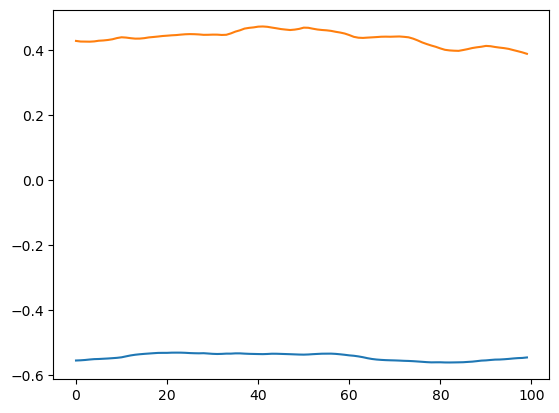

In [583]:
plt.plot(hand)
plt.plot(hand_nd)
plt.show()